# ADA - Final project
This notebook aims at giving technical explanations necessary to understand how the results given in the final report were found.

First off, the following commands allow you to retrieve the data necessary to run this notebook locally from the cluster used for this class.
1. Upload the files script.sh and script.py using the following command:  
```bash 
scp -r -p /path/to/script.py GASPAR@iccluster028.iccluster.epfl.ch:/home/GASPAR/script.py  
scp -r -p /path/to/script.sh GASPAR@iccluster028.iccluster.epfl.ch:/home/GASPAR/script.sh
```
2. Connect to the cluster using a second terminal and run the scripts:  
```bash 
ssh GASPAR@iccluster028.iccluster.epfl.ch  
sh script.sh script.py  
```
3. Store the output in the home folder:  
```bash 
hadoop fs -get /user/GASPAR/politics_2016_* file:///home/GASPAR
```
4. Download the data locally using the first terminal:  
```bash 
scp -r GASPAR@iccluster028.iccluster.epfl.ch:/home/GASPAR/politics_2016_* /local/path/to/folder
```

The retrieved dataset consists of several different features listed below:
* **author**: The username of the author of the comment.
* **author_flair_text**: Users can pick so-called *flairs* which are basically tags intended to briefly summarize the user.  They're different for each subreddit, and users can only pick one per subreddit.
* **body**: The content of the comment.
* **created_utc**: The date at which the comment was originally posted.
* **gilded**: Denotes if the comment received a gold. A gold is a form of gratification users can give one another. They're not common because gilding someone costs money.
* **id**: A unique ID that defines the comment.
* **link_id**: A unique ID that determines the post in which the comment was posted to.
* **parent_id**: A unique ID that determines to what the comment is responding to. If it starts with *t1*, the comment is a response to another comment. If it starts with *t3*, the comment is responding directly to the original post.
* **score**: The number of upvotes minus the number of downvotes the comment received.


## Imports

In [22]:
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import string

%matplotlib inline

## Loading data

In [3]:
DATA_PATH = 'data/'

In [4]:
city_states = colors = pd.read_csv(DATA_PATH + 'us_cities_states_counties.csv', delimiter = '|')

In [5]:
politics_06 = pd.read_parquet(DATA_PATH + 'politics_2016_06/')
politics_07 = pd.read_parquet(DATA_PATH + 'politics_2016_07/')
politics_08 = pd.read_parquet(DATA_PATH + 'politics_2016_08/')
politics_09 = pd.read_parquet(DATA_PATH + 'politics_2016_09/')
politics_10 = pd.read_parquet(DATA_PATH + 'politics_2016_10/')
politics_11 = pd.read_parquet(DATA_PATH + 'politics_2016_11/')

## Cleaning data

Features are converted into appropriate format.  
Redundant data are removed as well.  
  
It is possible to retrieve if the comment was responding to a post or to another comment by matching *link_id* and *parent_id*.

In [6]:
# created_utc is converted to the datetime format
politics_06['created_utc'] = pd.to_datetime(politics_06['created_utc'], unit='s')
politics_07['created_utc'] = pd.to_datetime(politics_07['created_utc'], unit='s')
politics_08['created_utc'] = pd.to_datetime(politics_08['created_utc'], unit='s')
politics_09['created_utc'] = pd.to_datetime(politics_09['created_utc'], unit='s')
politics_10['created_utc'] = pd.to_datetime(politics_10['created_utc'], unit='s')
politics_11['created_utc'] = pd.to_datetime(politics_11['created_utc'], unit='s')

# author_flair_text is converted to a category
politics_06['author_flair_text'] = politics_06['author_flair_text'].astype('category')
politics_07['author_flair_text'] = politics_07['author_flair_text'].astype('category')
politics_08['author_flair_text'] = politics_08['author_flair_text'].astype('category')
politics_09['author_flair_text'] = politics_09['author_flair_text'].astype('category')
politics_10['author_flair_text'] = politics_10['author_flair_text'].astype('category')
politics_11['author_flair_text'] = politics_11['author_flair_text'].astype('category')

# remove unnecessary information in link_id and parent_id
politics_06['link_id'] = politics_06['link_id'].str.slice(3)
politics_07['link_id'] = politics_07['link_id'].str.slice(3)
politics_08['link_id'] = politics_08['link_id'].str.slice(3)
politics_09['link_id'] = politics_09['link_id'].str.slice(3)
politics_10['link_id'] = politics_10['link_id'].str.slice(3)
politics_11['link_id'] = politics_11['link_id'].str.slice(3)
politics_06['parent_id'] = politics_06['parent_id'].str.slice(3)
politics_07['parent_id'] = politics_07['parent_id'].str.slice(3)
politics_08['parent_id'] = politics_08['parent_id'].str.slice(3)
politics_09['parent_id'] = politics_09['parent_id'].str.slice(3)
politics_10['parent_id'] = politics_10['parent_id'].str.slice(3)
politics_11['parent_id'] = politics_11['parent_id'].str.slice(3)


In [7]:
politics_06.head()

,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score
0,wheresthecheese,NaN,I'm very glad I read that. The first well thou...,2016-06-01 00:00:00,0,d3r38dt,4lxbri,4lxbri,3
1,ifCreepyImJoking,NaN,"Eh, once you start adding qualifiers instead o...",2016-06-01 00:00:03,0,d3r38gd,4lwef1,d3r17zv,0
2,Sam_Munhi,NaN,How so? Clinton and Trump are the two most dis...,2016-06-01 00:00:12,0,d3r38n2,4lxbzg,d3r0tm6,4
3,VowOfKsitigarbha,NaN,Is he attacking the wrong target?,2016-06-01 00:00:12,0,d3r38n4,4lycd3,4lycd3,25
4,iAMADisposableAcc,NaN,"We can agree on that, although I guess we have...",2016-06-01 00:00:15,0,d3r38q3,4lw22m,d3r2rv0,2


Dataframes for each month are then concatenated into one massive Dataframe whose data types are just as expected.

In [8]:
politics = pd.concat([politics_06, politics_07, politics_08, politics_09, politics_10, politics_11]).reset_index()
politics['author_flair_text'] = politics['author_flair_text'].astype('category') #necessary to do it again

In [9]:
politics.dtypes

index                         int64
author                       object
author_flair_text          category
body                         object
created_utc          datetime64[ns]
gilded                        int64
id                           object
link_id                      object
parent_id                    object
score                         int64
dtype: object

In [10]:
politics.describe()

,index,gilded,score
count,1.086033e+07,1.086033e+07,1.086033e+07
mean,9.539365e+05,3.835981e-04,6.766324e+00
std,6.041415e+05,2.441999e-02,5.706394e+01
min,0.000000e+00,0.000000e+00,-8.620000e+02
25%,4.525130e+05,0.000000e+00,1.000000e+00
50%,9.050270e+05,0.000000e+00,1.000000e+00
75%,1.370547e+06,0.000000e+00,4.000000e+00
max,2.522909e+06,1.400000e+01,1.901100e+04


In [11]:
politics.head()

,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score
0,0,wheresthecheese,NaN,I'm very glad I read that. The first well thou...,2016-06-01 00:00:00,0,d3r38dt,4lxbri,4lxbri,3
1,1,ifCreepyImJoking,NaN,"Eh, once you start adding qualifiers instead o...",2016-06-01 00:00:03,0,d3r38gd,4lwef1,d3r17zv,0
2,2,Sam_Munhi,NaN,How so? Clinton and Trump are the two most dis...,2016-06-01 00:00:12,0,d3r38n2,4lxbzg,d3r0tm6,4
3,3,VowOfKsitigarbha,NaN,Is he attacking the wrong target?,2016-06-01 00:00:12,0,d3r38n4,4lycd3,4lycd3,25
4,4,iAMADisposableAcc,NaN,"We can agree on that, although I guess we have...",2016-06-01 00:00:15,0,d3r38q3,4lw22m,d3r2rv0,2


In [12]:
print(set(politics['author_flair_text'].dropna()))
print(len(set(politics['author_flair_text'].dropna())))

{'Pennsylvania', 'Popcorn Express', 'Hector Sigala, NWWA', 'Maine Ranked Choice Voting Campaign', 'David Daley, Author - "Ratf**ked"', 'Russ Feingold (D-WI)', 'California', 'Idaho', 'Scott Wiener (D-CA)', 'Kentucky', 'Commissioner Walter Deleon (DC)', 'Jim Burke (D-TX)', 'Guam', 'Margaret Stock, AK senate candidate (I)', 'Louisiana', 'Matt Mitchell, founder of CryptoHarlem', 'Iowa', 'Maine', 'Damien LaVera NWWA', 'Sr. Economic Analyst', 'Popcorn with extra salt.', 'Alex Merced (L-NY)', 'Missouri', 'Pamela Smith, President of Verified Voting', 'abolition.org', 'Jesse Ventura (I-MN)', 'Evan Siegfried, author of "GOP GPS"', 'Mississippi', 'Colorado', 'Puerto Rico', 'North Dakota', 'District Of Columbia', 'Harri Hursti, creator of the Hursti Hack', 'Utah', 'West Virginia', 'Oklahoma', 'NORML', 'Massachusetts', 'Nevada', 'Mayor Matthew Avitabile (Middleburgh, NY)', 'Vermont', 'South Carolina', 'Zephyr Teachout (D-NY)', 'Josh Hendler, NWWA', 'Arkansas', 'Wyoming', 'KNOW 1-491', 'Delaware', '

In [13]:
state_full = set(np.array(city_states['State full'].dropna()))
print(state_full)
print(len(state_full))

{'Pennsylvania', 'Massachusetts', 'US Armed Forces Europe', 'Nevada', 'Wisconsin', 'Rhode Island', 'Vermont', 'South Carolina', 'Virgin Islands', 'New Hampshire', 'Arkansas', 'Wyoming', 'Delaware', 'Northern Mariana Islands', 'Georgia', 'Virginia', 'California', 'Tennessee', 'Washington, D.C.', 'Michigan', 'Idaho', 'Kentucky', 'Palau', 'Ohio', 'Guam', 'Montana', 'Louisiana', 'Texas', 'Arizona', 'Iowa', 'Maine', 'South Dakota', 'US Armed Forces Pacific', 'Marshall Islands', 'Oregon', 'Minnesota', 'New York', 'Missouri', 'Connecticut', 'Alaska', 'Illinois', 'Kansas', 'Nebraska', 'Hawaii', 'Washington', 'Florida', 'New Jersey', 'Mississippi', 'American Samoa', 'Colorado', 'Maryland', 'Alabama', 'Puerto Rico', 'North Dakota', 'Federated States of Micronesia', 'North Carolina', 'New Mexico', 'Indiana', 'Utah', 'West Virginia', 'Oklahoma'}
61


In [14]:
flair_politics = politics[politics['author_flair_text'].isin(state_full)]
print(set(flair_politics['author_flair_text']))
len(set(flair_politics['author_flair_text']))

{'Pennsylvania', 'Massachusetts', 'Nevada', 'Wisconsin', 'Rhode Island', 'Vermont', 'South Carolina', 'New Hampshire', 'Arkansas', 'Wyoming', 'Delaware', 'Georgia', 'California', 'Virginia', 'Tennessee', 'Idaho', 'Michigan', 'Kentucky', 'Ohio', 'Guam', 'Montana', 'Louisiana', 'Oklahoma', 'Texas', 'Arizona', 'Iowa', 'Maine', 'Oregon', 'South Dakota', 'Minnesota', 'New York', 'Missouri', 'Connecticut', 'Alaska', 'Illinois', 'Washington', 'Kansas', 'Nebraska', 'Hawaii', 'Florida', 'New Jersey', 'Mississippi', 'Colorado', 'Maryland', 'Alabama', 'Puerto Rico', 'North Dakota', 'North Carolina', 'New Mexico', 'Indiana', 'Utah', 'West Virginia', 'American Samoa'}


53

In [15]:
print(flair_politics.shape)
flair_politics.head()

(215850, 10)


,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score
6147305,1669459,Qu1nlan,California,Hi `juno255`. Thank you for participating in /...,2016-09-30 02:31:46,0,d87sxgv,5552n9,5552n9,1
6147372,1669526,Qu1nlan,California,Hi `Alejandro_Last_Name`. Thank you for partic...,2016-09-30 02:33:36,0,d87t05c,5556yb,5556yb,1
6147390,1669544,Qu1nlan,California,Hi `ImNotJesus`. Thank you for participating i...,2016-09-30 02:33:57,0,d87t0p2,5548v7,5548v7,1
6147458,1669612,Qu1nlan,California,Hi `cmonshoe`. Thank you for participating in ...,2016-09-30 02:35:17,0,d87t2mq,5541x2,5541x2,1
6147507,1669661,Qu1nlan,California,Hi `abourne`. Thank you for participating in /...,2016-09-30 02:36:23,0,d87t4ep,554okj,554okj,1


## Processing data

In [81]:
def nlp_entity(body):
    """Creates a string with each named entity preceded by its corresponding tag and separated with a comma"""
    entities = ''
    for sent in nltk.sent_tokenize(body):
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
            if hasattr(chunk, 'label'):
                 entities += (chunk.label() + ' ' + ' '.join(c[0] for c in chunk) + ',' )
    return entities[:-1]
                
def nlp_sentiment(body, sid=SentimentIntensityAnalyzer()):
    """Creates a string containing 4 numeric values corresponding to a sentiment analysis
    oredered as such compound, neg, neu, pos separated by a comma."""
    ss = sid.polarity_scores(body)
    sentiment = ""
    for k in sorted(ss):
        sentiment += '{},'.format(ss[k])
    return sentiment[:-1]

def nlp_wordcount(body, lemmatizer=nltk.WordNetLemmatizer(), stops=set(nltk.corpus.stopwords.words("english"))):
    """Returns a dictionnary with words frequency easily plottable."""
    fdist = nltk.FreqDist()
    body = body.translate(str.maketrans('','',string.punctuation))
    tokens = nltk.word_tokenize(body)
    filtered_words = [word for word in tokens if word not in stops and len(word) > 1]
    for word in filtered_words:
        fdist[lemmatizer.lemmatize(word.lower())] += 1      
    return fdist

def sentiment_to_label(sentiment):
    ss = sentiment.split(',')
    compound = float(ss[0])
    if (compound > 0.2):
        return "Positive"
    elif (compound < -0.2):
        return "Negative"
    else:
        return "Neutral"

In [82]:
sample = politics.sample(10).copy()

sample['entity'] = sample['body'].apply(nlp_entity)
sample['sentiment'] = sample['body'].apply(nlp_sentiment)
sample['wordcount'] = sample['body'].apply(nlp_wordcount)
sample['label'] = sample['sentiment'].apply(sentiment_to_label)
sample

,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
6878203,681127,Nautigirl,NaN,I have a friend who lives in Florida now that ...,2016-10-10 17:13:11,0,d8m34al,56pu13,d8ltrbg,1,"GPE Florida,GSP US","0.7783,0.049,0.824,0.127","{'friend': 1, 'life': 1, 'florida': 1, 'come':...",Positive
9508024,1170608,TORFdot0,NaN,Maybe there is a subset of people who are to b...,2016-11-11 20:53:34,0,d9wc3e5,5cegka,d9w7j7z,3,"GPE Reddit,PERSON Woodrow Wilson","-0.815,0.142,0.858,0.0","{'maybe': 1, 'subset': 1, 'people': 1, 'blame'...",Negative
9717356,1379940,Jaspion0,NaN,You would be wrong. Just watch the introductio...,2016-11-14 04:58:55,0,d9zg9il,5csz1g,d9zg1qz,8,"GPE Idiocracy,ORGANIZATION GOP,ORGANIZATION GOP","-0.8661,0.196,0.754,0.05","{'you': 1, 'would': 1, 'wrong': 1, 'just': 1, ...",Negative
2710725,1418220,timmyjj3,NaN,Yeah what the hell. FOIA exists. Hillary skirt...,2016-07-27 16:46:22,0,d5t5s0j,4uvemy,d5t56n7,2,"ORGANIZATION FOIA,PERSON Hillary,GSP US,ORGANI...","-0.7501,0.173,0.739,0.088","{'yeah': 1, 'hell': 1, 'foia': 2, 'exists': 1,...",Negative
10175525,1838109,Nosrac88,NaN,TBH I would not hire a guy that goes around sa...,2016-11-19 23:04:18,0,da7hz0r,5dtwk5,da79wmy,1,,"-0.6124,0.222,0.778,0.0","{'tbh': 1, 'would': 1, 'hire': 1, 'guy': 1, 'g...",Negative
9096710,759294,Jokrtothethief,NaN,Thanks.....,2016-11-09 05:20:15,0,d9sbda1,5bygln,d9sb9nh,4,GPE Thanks,"0.0,0.0,1.0,0.0",{'thanks': 1},Neutral
6516915,319839,SomeStupidJerk,NaN,No evidence for this at all.,2016-10-06 18:39:43,0,d8gsnui,566ldv,d8gqlbm,-1,,"-0.296,0.306,0.694,0.0","{'no': 1, 'evidence': 1}",Negative
190660,190660,Dorfidiot,NaN,"Maaaan, it is going to be soooooo sweet to wat...",2016-06-05 11:34:35,0,d3wq94e,4mjb63,4mjb63,1,GPE Maaaan,"0.6705,0.08,0.708,0.212","{'maaaan': 1, 'going': 2, 'soooooo': 1, 'sweet...",Positive
8994035,656619,[deleted],NaN,[removed],2016-11-09 01:01:01,0,d9ryd5z,5bwmxp,5bwmxp,1,,"0.0,0.0,1.0,0.0",{'removed': 1},Neutral
5738649,1260803,Pound_Cake,NaN,"[""Brandished"" with reference to a dangerous we...",2016-09-24 18:35:55,0,d80ebyp,546s0r,d8051ep,2,,"-0.9531,0.238,0.762,0.0","{'brandished': 1, 'reference': 1, 'dangerous':...",Negative


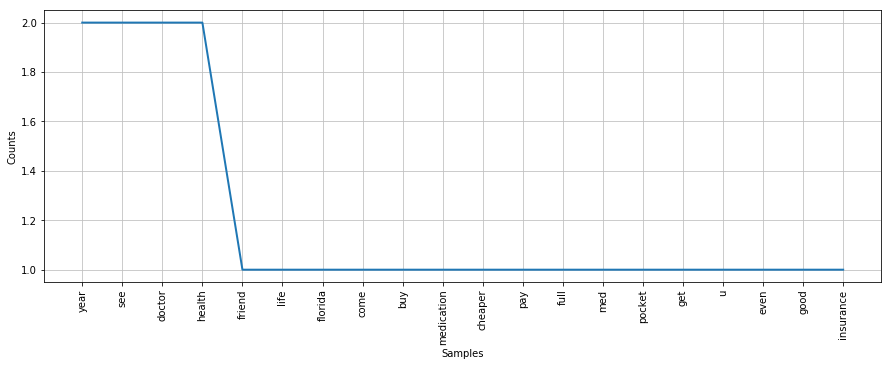

In [84]:
plt.figure(figsize=(15,5))
nltk.FreqDist(dict(sample.iloc[0]['wordcount'].most_common(20))).plot()


### Words positive or negative
Using flair only dataset

In [103]:
def get_word_count(df, sentiment):
    """ Get the word count according to the sentiment. Can be 'Positive', 'Negative', 'Neutral' or 'None' """
    if sentiment != 'None':
        filtered_df = df[df['label'] == sentiment]
    else:
        filtered_df = df.copy()
    fdists = list(filtered_df['wordcount'])
    tot_fd = nltk.FreqDist()
    for fdist in fdists:
        for key in fdist:
            tot_fd[key] += fdist.get(key)
            
    return tot_fd

sample_sorted_score = flair_politics.copy().sort_values(by=['score'], ascending=False)
sample_sorted_score['entity'] = sample_sorted_score['body'].apply(nlp_entity)
sample_sorted_score['sentiment'] = sample_sorted_score['body'].apply(nlp_sentiment)
sample_sorted_score['wordcount'] = sample_sorted_score['body'].apply(nlp_wordcount)
sample_sorted_score['label'] = sample_sorted_score['sentiment'].apply(sentiment_to_label)
sample_sorted_score.head()

,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
10003704,1666288,PoliticsBTFO,Texas,Bernie is in the title. This will get 5000 upv...,2016-11-17 15:11:14,3,da491ew,5dfjg3,da47ua7,8351,"PERSON Bernie,PERSON Trumps,PERSON Pentagon,PE...","-0.3786,0.113,0.782,0.105","{'bernie': 3, 'title': 1, 'this': 2, 'get': 2,...",Negative
7091994,894918,ellouelle,California,&gt;here come the rape police\n\nActual police...,2016-10-13 11:32:27,1,d8q3twj,579rh0,d8q3t61,6420,,"-0.6908,0.299,0.701,0.0","{'gthere': 1, 'come': 2, 'rape': 1, 'police': ...",Negative
10648484,2311068,lipsyncforyourlife,Florida,So the guy is saying there are a ton of illega...,2016-11-27 21:13:46,0,dai1myk,5f7jw2,5f7jw2,6084,,"-0.7622,0.213,0.787,0.0","{'so': 1, 'guy': 2, 'saying': 1, 'ton': 1, 'il...",Negative
6996195,799119,anon902503,Wisconsin,"DON'T LISTEN TO THE LIBERAL ""FACT"" POLICE. CA...",2016-10-12 02:37:03,1,d8o9mca,571wsx,571wsx,5165,"ORGANIZATION LIBERAL,ORGANIZATION YOUR,ORGANIZ...","0.4995,0.0,0.823,0.177","{'dont': 1, 'listen': 1, 'to': 1, 'the': 1, 'l...",Positive
10612075,2274659,HarlanCedeno,Georgia,"I'm not a Bernie supporter, but I'm kind of fa...",2016-11-27 00:47:06,0,dagz9cq,5f2ht6,5f2ht6,5034,"GPE Bernie,ORGANIZATION Congress,PERSON Trump","0.3723,0.132,0.726,0.142","{'im': 2, 'bernie': 1, 'supporter': 1, 'kind':...",Positive


#### Taking good scores into account

In [85]:
good_score = sample_sorted_score[sample_sorted_score['score'] > 50].copy()

In [86]:
word_positive_good = get_word_count(good_score, 'Positive')
word_negative_good = get_word_count(good_score, 'Negative')
word_count_good = get_word_count(good_score, 'None')

In [87]:
word_positive_good.most_common(10)

[('he', 25),
 ('trump', 16),
 ('like', 14),
 ('one', 13),
 ('the', 12),
 ('people', 11),
 ('way', 11),
 ('thats', 10),
 ('im', 10),
 ('party', 9)]

In [88]:
word_negative_good.most_common(10)

[('trump', 29),
 ('he', 22),
 ('it', 14),
 ('people', 13),
 ('think', 12),
 ('one', 11),
 ('said', 11),
 ('would', 11),
 ('the', 10),
 ('dont', 10)]

In [89]:
word_count_good.most_common(10)

[('trump', 54),
 ('he', 48),
 ('people', 31),
 ('one', 28),
 ('like', 26),
 ('think', 26),
 ('it', 25),
 ('the', 25),
 ('get', 22),
 ('thats', 20)]

#### Bad scores

In [90]:
bad_score = sample_sorted_score[sample_sorted_score['score'] < 0].copy()

bad_score.head()

,index,author,author_flair_text,body,created_utc,gilded,id,link_id,parent_id,score,entity,sentiment,wordcount,label
6480438,283362,Mister_Jay_Peg,Colorado,"No, because anyone who thinks it was governmen...",2016-10-05 23:43:46,0,d8fqyg1,562ejz,d8fqv8t,-1,"ORGANIZATION ONE,ORGANIZATION SANE,ORGANIZATIO...","-0.8122,0.134,0.821,0.045","{'no': 1, 'anyone': 1, 'think': 2, 'government...",Negative
6400902,203826,gorilla_eater,New York,"&gt; As for 3rd party, how about just THREE DA...",2016-10-04 21:34:07,0,d8e4deb,55v6u8,d8dy6n3,-1,"ORGANIZATION THREE,ORGANIZATION Sanders","0.8883,0.052,0.815,0.133","{'gt': 1, 'a': 1, '3rd': 1, 'party': 3, 'three...",Positive
7887846,1690770,conanthecnidarian,Texas,Which is still better than the triple digit in...,2016-10-24 21:46:55,0,d966o2g,5976k1,5976k1,-1,,"0.4404,0.0,0.838,0.162","{'which': 1, 'still': 1, 'better': 1, 'triple'...",Positive
6703006,505930,loki8481,New Jersey,&gt; The only thing I see is public looking an...,2016-10-09 13:29:17,0,d8keo0o,56luzl,d8keihz,-1,"PERSON Bernie Sanders,PERSON George W Bush,FAC...","0.7184,0.024,0.886,0.089","{'gt': 1, 'the': 1, 'thing': 2, 'see': 1, 'pub...",Positive
9664575,1327159,poochyenarulez,Alabama,Here is a list of some attacks involving Clint...,2016-11-13 17:42:05,0,d9ymjuh,5cqa9y,5cqa9y,-1,"PERSON Clinton,PERSON Trump","-0.0258,0.249,0.506,0.245","{'here': 1, 'list': 1, 'attack': 1, 'involving...",Neutral


In [91]:
word_positive_bad = get_word_count(bad_score, 'Positive')
word_negative_bad = get_word_count(bad_score, 'Negative')
word_count_bad = get_word_count(bad_score, 'None')

In [92]:
word_positive_bad.most_common(10)

[('trump', 31),
 ('would', 13),
 ('supporter', 11),
 ('dont', 11),
 ('gt', 9),
 ('people', 9),
 ('thing', 9),
 ('really', 9),
 ('need', 9),
 ('clinton', 9)]

In [93]:
word_negative_bad.most_common(10)

[('people', 23),
 ('trump', 20),
 ('gun', 19),
 ('hillary', 15),
 ('clinton', 14),
 ('one', 13),
 ('think', 12),
 ('like', 12),
 ('dont', 11),
 ('gt', 11)]

In [94]:
word_count_bad.most_common(10)

[('trump', 62),
 ('people', 41),
 ('hillary', 31),
 ('clinton', 30),
 ('gt', 25),
 ('one', 24),
 ('dont', 24),
 ('like', 23),
 ('think', 22),
 ('im', 22)]

#### Compare good and bad
Which one are in both sets?

In [95]:
both = []
good_only = nltk.FreqDist()
for good in word_count_good:
    if good in word_count_bad:
        both.append(good)
    else:
        good_only[good] = word_count_good.get(good)

In [96]:
both[:10]

['what',
 'ive',
 'heard',
 'friend',
 'right',
 'last',
 'government',
 'it',
 'doesnt',
 'matter']

In [97]:
good_only.most_common(10)

[('banned', 8),
 ('power', 7),
 ('mod', 6),
 ('obstruction', 5),
 ('set', 5),
 ('fire', 5),
 ('consent', 5),
 ('worst', 5),
 ('quran', 5),
 ('agenda', 4)]

In [98]:
bad_only = nltk.FreqDist()
for bad in word_count_bad:
    if bad not in word_count_good:
        bad_only[bad] = word_count_bad.get(bad)

In [99]:
bad_only.most_common(10)

[('gun', 20),
 ('keep', 10),
 ('liberal', 9),
 ('rigged', 9),
 ('article', 7),
 ('sander', 6),
 ('today', 6),
 ('evidence', 6),
 ('illegal', 5),
 ('internet', 5)]

## Entities

In [100]:
def get_score(row, firstName, lastName, out_states):
    current_state = row['author_flair_text']
    if firstName in row['entity'] or lastName in row['entity']:
        if row['label'] == 'Positive':          
            out_states.loc[current_state, 'score_'+lastName] += 1
        elif row['label'] == 'Negative':
            out_states.loc[current_state, 'score_'+lastName] -= 1

In [102]:
state_list = list(set(state_full))
state_df = pd.DataFrame(state_list, columns=['name'])
state_df.set_index('name', inplace=True)
state_df['score_Trump'] = 0
state_df['score_Clinton'] = 0

sample_sorted_score.apply(get_score, firstName='Donald', lastName='Trump', out_states=state_df, axis=1)
sample_sorted_score.apply(get_score, firstName='Hillary', lastName='Clinton', out_states=state_df, axis=1)


state_df

,score_Trump,score_Clinton
name,,
Pennsylvania,7,5
Massachusetts,-7,0
US Armed Forces Europe,0,0
Nevada,2,1
Wisconsin,4,0
Rhode Island,-1,1
Vermont,-4,0
South Carolina,2,-1
Virgin Islands,0,0


In [36]:
#TODO plot

## Visualizing data

To get a feel for the dataset, a histogram with the number of comments for each day is plotted.

In [37]:
# computation of the number of days the dataset spans
days = (politics.iloc[-1].created_utc - politics.iloc[0].created_utc).days + 1

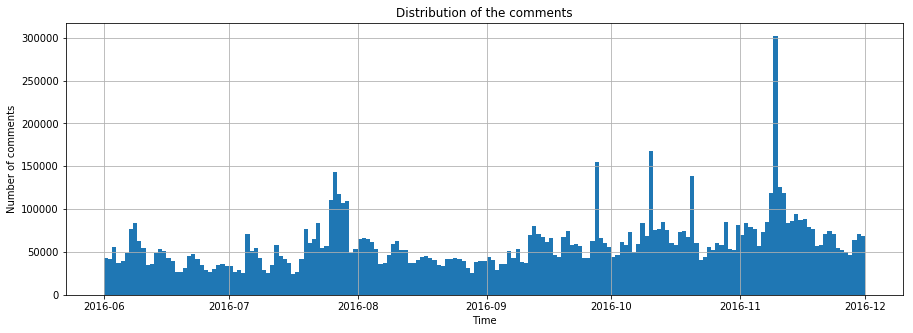

In [38]:
plt.figure(figsize=(15,5))
plt.grid()
plt.hist(politics['created_utc'], bins=days)
plt.ylabel('Number of comments')
plt.xlabel('Time')
plt.title('Distribution of the comments')
plt.show()